## Web Service Client

En este notebook vamos a consumir un servicio de machine learning. El servicio debe ser levantando con el script server.py por separado.

In [14]:
import requests

# url del servicio
url = 'http://127.0.0.1:1080/predict'

# cuerpo del mensaje
body = {
    "petal_length": "2.1",
    "sepal_length": "2",
    "petal_width": "0.5",
    "sepal_width": "3"
}

# enviamos los datos por POST
response = requests.post(url, data=body)

# imprimimos el mensaje
print(response.json())

{'Prediccion': 2}


### EJERCICIO 1: 

Modifique el server.py para que acepte requests por GET. Modifique el codigo del cliente para enviar los datos por GET

In [15]:
# DEFINA SU CLIENTE GET AQUI:
import requests

# url del servicio
url = 'http://127.0.0.1:1080/predict'

# cuerpo del mensaje
payload = {
    "petal_length": "2.1",
    "sepal_length": "2",
    "petal_width": "0.5",
    "sepal_width": "3"
}

# enviamos los datos por POST
response = requests.get(url, params=payload)

# imprimimos el mensaje
print(response.json())


{'Prediccion': 2}


### EJERCICIO 2:

* Entrene un modelo de machine learning con MNIST y salve su modelo en un archivo pickle. [MNIST classification using multinomial logistic + L1](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html)
* Modifique el server.py para que agregue la ruta /predict-number y que sea capaz de predecir si una imagen pertecene a un numero del 0 al 9
* Va a enviar la imagen desde el cliente (este notebook) como un base64 hacia el server.py
* el server.py va recibir la imagen la reconstruye en una imagen nuevamente y la manda al modelo de ML
* la imagen que ingresa al server.py debe salvarla en un folder (images)

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

### Download the data

In [2]:
# Load data from https://www.openml.org/d/554
X_data, y_data = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
print(X_data.shape)
print(y_data.shape)

(70000, 784)
(70000,)


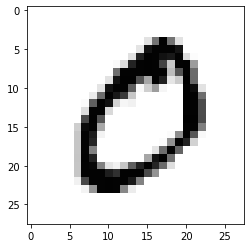

In [3]:
img = X_data[1].reshape((28,28))
plt.imshow(img, cmap="Greys")

### Train the model

Sparsity with L1 penalty: 79.35%
Test score with L1 penalty: 0.8394


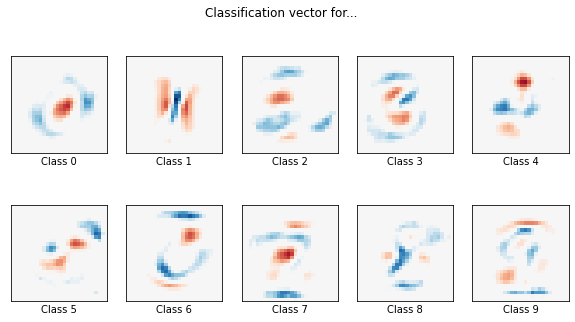

In [171]:
train_samples = 5000

X = np.copy(X_data)
y = np.copy(y_data)

permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(
    C=50. / train_samples, penalty='l1', solver='saga', tol=0.1
)
clf.fit(X_train, y_train)

# Print stats
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

plt.show()

### Save the model

In [172]:
pkl_filename = "mnist_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

### Load the model

In [173]:
pkl_filename = "mnist_model.pkl"

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

shape:  (784,)
number: 9


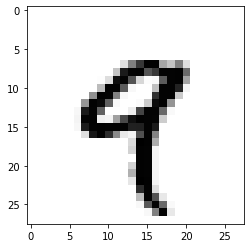

In [196]:
item_to_test = X_data[4]
img = item_to_test.reshape((28,28))
plt.imshow(img, cmap="Greys")

result = pickle_model.predict([item_to_test])

print('shape: ', item_to_test.shape)
print('number:', result[0])

In [185]:
new_im = Image.fromarray(img)

# https://stackoverflow.com/questions/16720682/pil-cannot-write-mode-f-to-jpeg
if new_im.mode != 'RGB':
    new_im = new_im.convert('RGB')

new_im.save("numpy_altered_sample2.jpg")

### Use the saved model

In [197]:
import base64
from PIL import Image
from io import BytesIO

# mnist expects 28*28 = 784
size = 28, 28

def encode_img(path):
    with open(path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    return encoded_string

def decode_img(encoded_string):    
    img = Image.open(BytesIO(base64.b64decode(encoded_string)))
    return img

# https://stackoverflow.com/questions/60103004/create-an-array-like-mnist-dataset-from-tinker-draw-python
def reshape_image(img):
    img.thumbnail(size, Image.ANTIALIAS) # resize
    img =  np.invert(img.convert('L')).ravel() # Convert to grayscale and set shape as (28,)
    
#     img = img / 255
    
    return img
    

(784,)

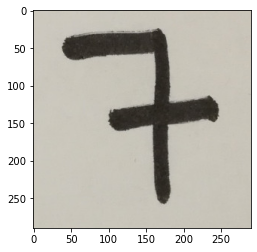

In [162]:
# Encode/Decode image for demo purposes.
# https://stackoverflow.com/a/58005335

img_encoded_7 = encode_img('data/seven.jpg')
img_7 = decode_img(img_encoded_7)
plt.imshow(img_7)


ds = reshape_image(img_7)
ds.shape

In [160]:
#### Número 6 cuya imagen original es de color

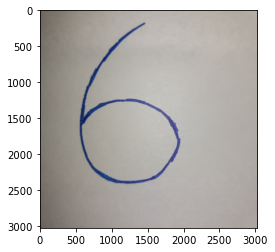

In [163]:
img_encoded_6 = encode_img('data/digit_six.jpg')
img_6 = decode_img(img_encoded_6)
plt.imshow(img_6)

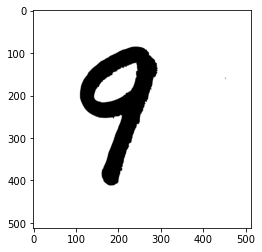

In [178]:
img_encoded_9 = encode_img('data/number-9.png')
img_9 = decode_img(img_encoded_9)
plt.imshow(img_9)

In [190]:
reshape_image(img_encoded_9)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [194]:
import requests

# url del servicio
url = 'http://127.0.0.1:1080/predict-number'

# cuerpo del mensaje
body = {
    "img": img_encoded_7
}

# enviamos los datos por POST
response = requests.post(url, data=body)

# imprimimos el mensaje
print(response.json())

{'result': '8'}
